In [2]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import pytorch_lightning as pl
import os
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
class CocoCaptionDataset(torch.utils.data.Dataset):
        def __init__(self, data):
            super().__init__()
            self.data = data

        def __getitem__(self, idx):
            return self.data[idx]

        def __len__(self):
            return len(self.data)
        
class CocoCaptionsLT(pl.LightningDataModule):
    
    def __init__(self, folder_path, batch_size = 64, caption_idx = 1, transformer = None):
        '''
        Input:
          folder_path: A folder that contains both train and validation images and annotation (.json)
          caption_idx: Original file contain 4 or 5 captions per image. We will only pick one according to index.
          transformers: Pytorch data transforms that will used during preprocess data. 
                        **All data are prepocessed during set up phase. i.e. no transform are used during training**
        '''
        assert caption_idx < 4

        super().__init__()
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.caption_idx = caption_idx
        self.transformer = transformer
        
        try:
            print(f'Loading coco2017_caption{self.caption_idx}_data_dict')
            self.data_dict = torch.load(os.path.join(folder_path, f'coco2017_caption{self.caption_idx}_data_dict'))
        except:
            self.data_dict = None
            train_img_path = os.path.join(folder_path, 'train2017')
            train_caption_path = os.path.join(folder_path, 'annotations/captions_train2017.json')
            val_img_path = os.path.join(folder_path,'val2017')
            val_caption_path = os.path.join(folder_path,'annotations/captions_val2017.json')

            if self.transformer is None:
                self.transformer = transforms.Compose([
                                                        transforms.Resize(112),
                                                        transforms.CenterCrop(112),
                                                        transforms.ToTensor()
                                                          ])

            self.train_dataset = torchvision.datasets.CocoCaptions(train_img_path, train_caption_path, transform = self.transformer)
            self.val_dataset = torchvision.datasets.CocoCaptions(val_img_path, val_caption_path, transform = self.transformer)
    
    def prepare_data(self):
        
        if self.data_dict is None:
            print('Load fail. Build dataset from scratch. This will take a while!!')
            self.vocab_to_idx, self.idx_to_vocab = self._create_vocab_idx_mapping(self.train_dataset, self.caption_idx)
            self.train_dataset = self._tokenize_captions(self.train_dataset, self.caption_idx, self.vocab_to_idx)
            self.val_dataset = self._tokenize_captions(self.val_dataset, self.caption_idx, self.vocab_to_idx)

            self.data_dict = {"vocab_to_idx": self.vocab_to_idx, 
                         "idx_to_vocab": self.idx_to_vocab, 
                         "train_dataset": self.train_dataset, 
                         "val_dataset": self.val_dataset,
                         'vocab_count':self.vocab_count}
            torch.save(self.data_dict, os.path.join(self.folder_path, f'coco2017_caption{self.caption_idx}_data_dict'))
        else:
            print('Load successful.')
            self.vocab_to_idx = self.data_dict["vocab_to_idx"]
            self.idx_to_vocab = self.data_dict["idx_to_vocab"]
            self.train_dataset = self.data_dict['train_dataset']
            self.val_dataset = self.data_dict['val_dataset']
            self.vocab_count = self.data_dict['vocab_count']
            
    def train_dataloader(self):
        trainDataLoader = torch.utils.data.DataLoader(self.train_dataset, self.batch_size,
                                                      shuffle=True, num_workers=1, pin_memory=True)
        return trainDataLoader
    
    def val_dataloader(self):
        valDataLoader = torch.utils.data.DataLoader(self.val_dataset, self.batch_size,
                                                      shuffle=True, num_workers=1, pin_memory=True)
        return valDataLoader
    
    def sample(self, num_samples= 4):
        idx = torch.randint(0, len(self.train_dataset), (num_samples,), dtype=torch.int)
   
        for i in idx:
            img, cap = self.train_dataset[i]
            plt.imshow(img.permute(1,2,0).numpy())
            plt.title(self._decode_captions(cap))
            plt.axis('off')
            plt.show()
            
  
    def _tokenize_captions(self, dataset, caption_idx, vocab_to_idx, fix_length= 16):
        '''
        Add <'START'> token at the beginning of the caption,
        Add <'END'> token at the end of the caption,
        Replace unknow words into <'UNK'> token,
        Pad caption to a fix length with <'NULL'> tokens
        and tanslate all into index and return as a Pytorch dataset

        Input:
          dataset: dataset which are gonna be used to count words
          caption_idx: Each image in original Coco dataset has 4-5 captions. 
                       We will only use *ONE* of them according to the index.
                       Index should be less than 4
        Return:
          dataset: Pytorch dataset which can be used in dataloader

        '''            
        assert caption_idx < 4
        print("Start tokenize dataset. This will take a while!!")

        master = []
        for image, captions in tqdm(dataset):

            caption = captions[caption_idx]
            caption = caption.lower().split()
            words= [vocab_to_idx['<START>']]
            for i in range(fix_length): 

                if i < len(caption):
                    word = caption[i].strip('.')
                    try:
                        words.append(vocab_to_idx[word])
                    except:
                        words.append(vocab_to_idx['<UNK>'])

                elif i == len(caption):
                    words.append(vocab_to_idx['<END>'])

                else:
                    words.append(vocab_to_idx['<NULL>'])

            master.append((image, torch.tensor(words)))
        return CocoCaptionDataset(master)



    def _create_vocab_idx_mapping(self, dataset, caption_idx, num_words= 1000):
        '''
        Use the first 5k examples to map vocabulary to idx and
        grab the first 1k most frequent words in the datasets

        Input:
          dataset: dataset which are gonna be used to count words
          caption_idx: Each image in original Coco dataset has 4-5 captions. 
                       We will only use *ONE* of them according to the index.
                       Index should be less than 4

        Output:
          vocab_to_idx: dictionary
          idx_to_vocab: list
        '''
        assert caption_idx < 4
        from collections import defaultdict
        print('Start creating vocab index mapping. This will take several minutes!!')

        smaller_dataset, _ = torch.utils.data.random_split(dataset, [5000, len(dataset)-5000])
        vocab_count = defaultdict(int)
        for _, captions in tqdm(smaller_dataset):
            caption = captions[caption_idx]
            caption = caption.lower().split()

            for word in caption:
                word = word.strip('.')
                if len(word) > 0:
                      vocab_count[word] += 1

        special_tokens = [('<NULL>', 0),('<START>', 0),('<END>', 0),('<UNK>', 0)]
        ordered = list(sorted(vocab_count.items(), key= lambda item: item[1], reverse=True))
        first1KTuple = sorted(ordered[:num_words-len(special_tokens)], key = lambda item: item[0])


        vocab_to_idx = {x[0] : i for x, i in zip(special_tokens + first1KTuple, range(num_words))}
        idx_to_vocab = [k for k, v in vocab_to_idx.items()]

        for i in range(num_words):
            word = idx_to_vocab[i]
            assert vocab_to_idx[word] == i, 'Vocab mapping failed, words are missed match'

        self.vocab_count = vocab_count
        return vocab_to_idx, idx_to_vocab
    
    def _decode_captions(self, captions):
        """
        Decoding caption indexes into words.
        Inputs:
        - captions: Caption indexes in a tensor of shape (Nx)T.
        - idx_to_word: Mapping from the vocab index to word.
        Outputs:
        - decoded: A sentence (or a list of N sentences).
        """
        singleton = False
        if captions.ndim == 1:
            singleton = True
            captions = captions[None]
        decoded = []
        N, T = captions.shape
        for i in range(N):
            words = []
            for t in range(T):
                word = self.idx_to_vocab[captions[i, t]]
                if word != '<NULL>':
                    words.append(word)
                if word == '<END>':
                    break
            decoded.append(' '.join(words))
        if singleton:
            decoded = decoded[0]
        return decoded

In [4]:
dataModuleLT = CocoCaptionsLT('/home/fred/datasets/coco/')
dataModuleLT.prepare_data()

Loading coco2017_caption1_data_dict
Load successful.


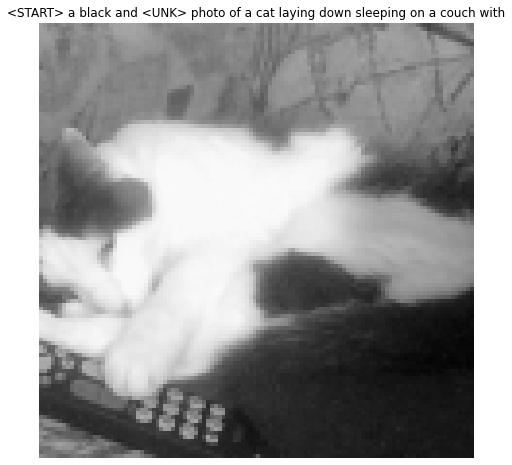

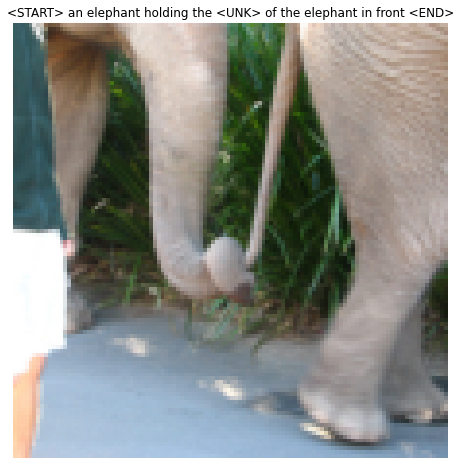

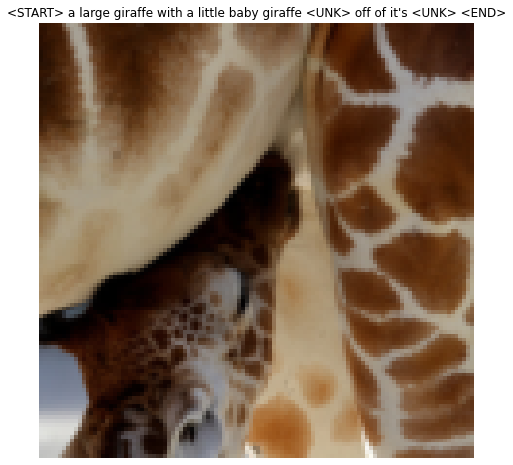

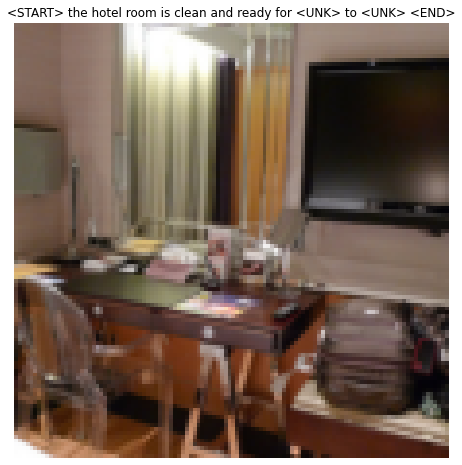

In [5]:
dataModuleLT.sample()